In [2]:
import numpy as np

# this class represents an implicit quadric of the form <Qx|x> + <b|x> + c = 0
class Quadric:
    def __init__(self,Q,b,c):
        self.Q = Q
        self.b = b
        self.c = c
        
    def __call__(self,x):
        return np.dot(x,self.Q@x) + np.dot(self.b,x) + self.c

    # compute the intersection of the quadric with the ray a+tv, t a real number.
    # returns the values of t corresponding to the intersection(s)
    def intersect_with_ray(self,a, v):
        A = np.dot(v,self.Q@v)
        B = 2*np.dot(a,self.Q@v) + np.dot(self.b,v)
        C = self.c + np.dot(self.b,a) + np.dot(a,self.Q@a)
    
        # linear case
        if np.abs(A) < 1e-7:
            if np.abs(B) > 1e-7:
                return [-C/B]
            else:
                return []
        
        Delta = B**2 - 4*A*C
        if Delta <= 0:
            #print("negative Delta={}".format(Delta))
            #print("a={}, v={}".format(a,v))
            return []
        sqrtDelta = np.sqrt(Delta)
        return [(-B+sqrtDelta)/(2*A), (-B-sqrtDelta)/(2*A)]

    # computes the intersection of the quadric with the segment [p,q], i.e.
    # points of the form (1-t) p + t q with t in [0,1]
    # returns the values of t corresponding to the intersection(s)
    def intersect_with_segment(self,p, q):
        T = self.intersect_with_ray(p, q-p)
        T = [t for t in T if (t >= 0) and t <= 1]
        return T
    
    # find the first intersection point of the quadric with the ray a+tv, t>=0 
    # assumption: quad(a)<0 and quad(b)>0
    def compute_first_intersection(self, a, v):
        S = np.array(self.intersect_with_ray(a, v))
        S = S[S>=-1e-5]
        if len(S) < 1:
            print("len(S)<1: {}".format(self.intersect_with_ray(a, v)))
            print("quad(a): {}".format(self(a)))
        return a + np.min(S) * v
    
    # returns a curve corresponding to the intersection of the triangle [p,q,bary] with the quadric
    # assumption: quad(p) = quad(q) = 0, quad(bary)>0
    def trace_curve(self, p, q, bary,N):
        p = p + 0.1*(bary-p)
        q = q + 0.1*(bary-q)
        R = np.zeros((N,3))
        h = 1.0/(N-1)
        for i in range(0,N):
            a = (1-i*h)*p+i*h*q
            #print("qa=%g, qb =%g"%(self(a), self(bary)))
            R[i] = self.compute_first_intersection(a, a-bary)
        return R

In [3]:
def find_point_above_quadric_in_polygon(quad, P):
    nv = len(P)
    bary = np.mean(P,0)
    
    # check if one vertex of the polygon is above
    above = None
    for p in P:
        if quad(p) <= 0:
            continue
        above = p + 1e-5*(bary - p)
        assert(quad(above)>0)
        return above

    # check if one segment intersects the quadric
    for v in range(nv):
        w = (v+1)%nv
        T = quad.intersect_with_segment(P[v], P[w])
        if len(T) == 0:
            continue
        if len(T) == 1:
            print("len(T) = 1", quad(P[v]), quad(P[w]))
        assert(len(T) == 2)
        q1 = P[v] + T[0]*(P[w] - P[v])
        q2 = P[v] + T[1]*(P[w] - P[v])
        above = (q1+q2)/2 + 1e-7*(np.mean(P,0) - P[v,:])
        if (quad(above) < 0):
            continue # segment is barely above....
            #print("quad(above)={}".format(quad(above)))
            #print("quad(q1)={}".format(quad(q1)))
            #print("quad(q2)={}".format(quad(q2)))
            #print("q1={}".format(q1))
            #print("q2={}".format(q2))
            #print("T={}".format(T))
        assert(quad(above)>0)
        return above
    
    # otherwise, the polygon does not intersect the quadric
    # BEWARE: we are neglecting the possibility that P intersects quad in its interior only...
    return None

# intersects the triangle [v,w,above] with the quadric
# assumption: quad(above) > 0
def intersect_triangle_with_quadric(quad, v, w, above, N=10):
    signv = np.sign(quad(v))
    signw = np.sign(quad(w))
    if (signv == 1) and (signw == 1): # everything is above: nothing to do
        return []
    elif (signv == 1) and (signw == -1): 
        T = quad.intersect_with_segment(v, w)
        assert len(T) == 1
        p = v + T[0]*(w - v)
        q = quad.compute_first_intersection(w, above-w)
        return [quad.trace_curve(p,q,above,N)]
    elif signv == -1 and signw == 1: 
        p = quad.compute_first_intersection(v, above-v)
        T = quad.intersect_with_segment(v, w)
        assert(len(T) == 1)
        q = v + T[0]*(w - v)
        return [quad.trace_curve(p,q,above,N)]
    elif signv == -1 and signw == -1: 
        pv = quad.compute_first_intersection(v, above-v)
        pw = quad.compute_first_intersection(w, above-w)
        T = quad.intersect_with_segment(v, w)
        if len(T) == 0:
            # all the segment is below the quadric
            return [quad.trace_curve(pv,pw, above, N)]
        
        assert len(T) == 2, "T={}".format(T)
        q1 = v + T[0]*(w - v)
        q2 = v + T[1]*(w - v)
        return [quad.trace_curve(pv,q1,above,N),
                quad.trace_curve(q2,pw,above,N)]

# returns the intersection between the polygon P with the quadric 
# assumption: P is flat, i.e. contained in a plane
# returns a list of curves (list of numpy arrays) describing the intersection
def intersect_polygon_with_quadric(P,quad,N=10):
    nv = len(P)
    sign = np.sign([quad(x) for x in P])
                
    # find point above quadric in P; if there is no such point, intersection is empty
    above = find_point_above_quadric_in_polygon(quad,P)
    if above is None:
        return []
    
    # compute the intersection between quad and the triangles of the form [v,w,above],
    # where v,w are vertices of P
    curves = []
    for v in range(nv):
        w = (v+1)%nv
        curves += intersect_triangle_with_quadric(quad, P[v], P[w], above)
    return curves        


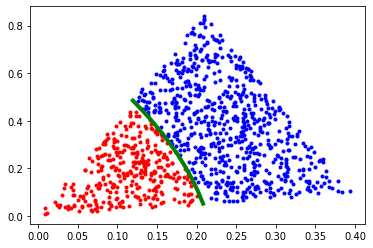

In [4]:
# check (visually) the computation of the intersection between a triangle and a quadric

import matplotlib.pyplot as plt
%matplotlib inline

# quad(x,y,z) = -x^2 - y^2 + z
# quad >= if z >= x^2 + y^2
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), -1)

above = np.array([0,0,2])
v = np.random.rand(3)
w = np.random.rand(3)
    
def trisample(A, B, C,N):
    r1 = np.random.rand(N)
    r2 = np.random.rand(N)
    s1 = np.sqrt(r1)

    X = np.zeros((N,3))
    X[:,0] = A[0] * (1.0 - s1) + B[0] * (1.0 - r2) * s1 + C[0] * r2 * s1
    X[:,1] = A[1] * (1.0 - s1) + B[1] * (1.0 - r2) * s1 + C[1] * r2 * s1
    X[:,2] = A[2] * (1.0 - s1) + B[2] * (1.0 - r2) * s1 + C[2] * r2 * s1
    return X

X = trisample(above,v,w,1000)
s = np.array([quad(x) for x in X])
plt.plot(X[s>0,0], X[s>0,1],'.r')
plt.plot(X[s<0,0], X[s<0,1],'.b')

curves = intersect_triangle_with_quadric(quad, v, w, above)
for c in curves:
    plt.plot(c[:,0], c[:,1],'g', linewidth=4)


In [5]:
import pypower

# computes the intersection of a cell = cell[i] of a Power diagram with the quadric
# returns a dictionnary mapping a neighbor j to a list of curves Pow_i \cap Pow_j \cap quad, 
# as returned by intersect_polygon_with_quadric
def intersect_cell_with_quadric(X, cell, quad, N = 10):
    curves = {}
    for j,P in cell.items(): # iterate over all facets
        P = np.array(P)
        curves[j] = intersect_polygon_with_quadric(P,quad,N)
    return curves

3.999999930684225


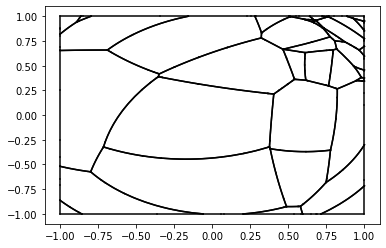

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)

N=100
X = np.random.rand(N,3)
w = np.zeros(N)
cells = pypower.power_diagram(X,w)

area = 0
for i in range(N):
    curves = intersect_cell_with_quadric(X,cells[i],quad,20)
    if curves is None:
        print("empty cell {}".format(i))
        continue
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for i in range(crv.shape[0]-1):
                a = crv[i,0:2]
                b = crv[i+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
            plt.plot(crv[:,0], crv[:,1], 'k')
print(area)

In [9]:
def areas_of_power_diagram_quadric_intersection(X,w,quad):
    N = len(w)
    cells = pypower.power_diagram(X,w)
    areas = np.zeros(N)
    for i in range(N):
        curves = intersect_cell_with_quadric(X,cells[i],quad,20)
        if curves is None:
            print("empty cell {}".format(i))
            continue
        # compute area of cell i by integrating over the boundary
        # j is the number of the adjacent cell (negative number if adjacency 
        # is with the boundary)
        for j,curvesj in curves.items():
            for crv in curvesj:
                crv = np.array(crv)
                for k in range(crv.shape[0]-1):
                    a = crv[k,0:2]
                    b = crv[k+1,0:2]
                    areas[i] += np.linalg.det(np.array([a,b]))/2
    return areas
 
N = 100
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)
X = np.random.rand(N,3)
w = np.zeros(N)
H = lambda w: areas_of_power_diagram_quadric_intersection(X,w,quad) - 4.0/N
H(w)

array([-0.04      , -0.04      , -0.03113171,  0.01273695, -0.03886087,
        0.00528593, -0.04      , -0.04      , -0.04      , -0.02905912,
       -0.04      , -0.04      ,  1.49163525, -0.03409039, -0.04      ,
       -0.04      , -0.04      , -0.04      , -0.0092797 , -0.0188632 ,
       -0.04      , -0.04      , -0.02170375, -0.04      , -0.01149568,
       -0.03898007, -0.04      , -0.04      , -0.04      , -0.02470531,
       -0.03810934, -0.02751911, -0.04      , -0.04      , -0.04      ,
       -0.04      , -0.04      , -0.03996055, -0.04      , -0.04      ,
       -0.0392248 , -0.04      , -0.04      , -0.04      , -0.03668184,
       -0.01854239,  0.26439068, -0.04      , -0.04      , -0.04      ,
       -0.04      , -0.04      , -0.04      , -0.04      , -0.04      ,
       -0.04      , -0.04      , -0.00723846,  0.05520041, -0.04      ,
       -0.04      ,  0.00323822, -0.04      , -0.04      , -0.03389386,
        0.27408714, -0.04      ,  0.28472999,  0.12106783, -0.04